# Derive models of spacecraft with star tracker

Do all imports.

In [477]:
import sympy as sym
import numpy as np
from IPython.display import display, Markdown
import ae353_spacecraft_design as design

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Create spacecraft

Create a visualizer to help with placement of reaction wheels.

In [478]:
# Create the visualizer
vis = design.create_visualizer()

# Show the visualizer in this notebook
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7042/static/


Specify the location of four reaction wheels in terms of their right ascension $\alpha$ and declination $\delta$. You cannot change the number of wheels, but it is likely that you **must** change the location of wheels in order for the system to be controllable.

In [479]:
wheels = [
    {"alpha": 0 * np.pi / 3 + np.pi / 3, "delta": np.arctan(0/np.sqrt(3))},
    {"alpha": 2 * np.pi / 3 + np.pi / 3, "delta": np.arctan(3./np.sqrt(3))},
    {"alpha": 4 * np.pi / 3 + np.pi / 3, "delta": np.arctan(3./np.sqrt(3))},
    {"alpha": 0 * np.pi / 3, "delta": -np.pi / 2},
]

Show wheels in the visualizer. You will be warned if any wheel obscures the star tracker (i.e., the "scope") or if any two wheels are too close together.

In [480]:
design.show_wheels(vis, wheels)

Create a model of the spacecraft in URDF format. This will **overwrite** the file `spacecraft.urdf` in the `urdf` directory. Also, compute the mass $m$ and inertia matrix $J$ of the spacecraft (including all the wheels). These parameters will be used later when deriving equations of motion.

In [481]:
m, J = design.create_spacecraft(wheels)

display(
    Markdown(
        r"$$"
        + rf"m = {sym.latex(np.round(m, decimals=2))}"
        + r" \qquad\qquad "
        + rf"J = {sym.latex(sym.Matrix(J.round(decimals=2)))}"
        + r"$$"
    )
)

$$m = 19.0 \qquad\qquad J = \left[\begin{matrix}31.95 & 0.0 & 0.0\\0.0 & 29.41 & 0.0\\0.0 & 0.0 & 22.38\end{matrix}\right]$$

## Create stars

Specify the location of at most ten stars in terms of their right ascension $\alpha$ and declination $\delta$. It is likely that you **must** change the number and/or location of stars in order for the system to be observable.

In [482]:
stars = [
    {
        "alpha": 0.00,
        "delta": 0.30,
    },  # <-- To add a star, append a copy of this dict to the list. To change
    #     the location of a star, change the value of alpha and delta
    {
        "alpha": -0.20,
        "delta": 0.20,
    },
    {
        "alpha": -0.30,
        "delta": 0.00,
    },
    {
        "alpha": -0.20,
        "delta": -0.20,
    },
    {
        "alpha": 0.00,
        "delta": -0.30,
    },
    {
        "alpha": 0.20,
        "delta": -0.20,
    },
    {
        "alpha": 0.30,
        "delta": 0.00,
    },
    {
        "alpha": 0.20,
        "delta": 0.20,
    }
]

In [483]:
def generate_stars(num_stars=10, radius=0.3):
    """
    Generate `num_stars` dictionaries, each with keys:
        "alpha" (right ascension)
        "delta" (declination)
    The stars are placed evenly around a circle of given `radius`
    in the (alpha, delta) plane.
    """
    stars = []
    for i in range(num_stars):
        alpha = radius * np.cos(2 * np.pi * i / num_stars)
        delta = radius * np.sin(2 * np.pi * i / num_stars)
        stars.append({
            "alpha": round(alpha, 4),
            "delta": round(delta, 4)
        })
    return stars

# Example usage:
stars = generate_stars(num_stars=8, radius=0.3)

Show where the stars will appear in the scope. The plot on the left shows $\alpha$ and $\delta$ gridelines. The plot on the right shows $y_\text{star}$ and $z_\text{star}$ gridlines.

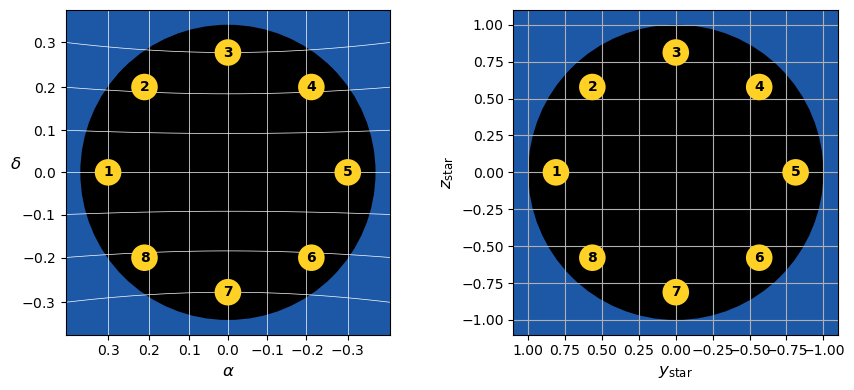

In [484]:
design.show_stars(stars)

Create a file with the location of stars. This will **overwrite** the file `stars.json` in the `urdf` directory.

In [485]:
design.create_stars(stars)

## Create dynamic model

Derive the equations of motion.

In [486]:
# Define yaw, pitch, roll angles
psi, theta, phi = sym.symbols("psi, theta, phi")

# Define angular velocities
w_x, w_y, w_z = sym.symbols("w_x, w_y, w_z")

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols("tau_1, tau_2, tau_3, tau_4")

# Compute resultant torques
T1 = -tau_1 * sym.Matrix(wheels[0]["xyz"]) / np.linalg.norm(wheels[0]["xyz"])
T2 = -tau_2 * sym.Matrix(wheels[1]["xyz"]) / np.linalg.norm(wheels[1]["xyz"])
T3 = -tau_3 * sym.Matrix(wheels[2]["xyz"]) / np.linalg.norm(wheels[2]["xyz"])
T4 = -tau_4 * sym.Matrix(wheels[3]["xyz"]) / np.linalg.norm(wheels[3]["xyz"])
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices
Rz = sym.Matrix(
    [[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]]
)
Ry = sym.Matrix(
    [
        [sym.cos(theta), 0, sym.sin(theta)],
        [0, 1, 0],
        [-sym.sin(theta), 0, sym.cos(theta)],
    ]
)
Rx = sym.Matrix(
    [[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]]
)

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
euler = sym.Matrix(
    [
        [(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
        [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
        [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)],
    ]
)

# Define equations of motion
f = sym.simplify(
    sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True
)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right).$$

Here is the function $f$:

In [487]:
print(f)

Matrix([[(w_y*sin(phi) + w_z*cos(phi))/cos(theta)], [w_y*cos(phi) - w_z*sin(phi)], [w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)], [-50000000*tau_1/3194518529 + 50000000*tau_2/3194518529 - 25000000*tau_3/3194518529 - 612323399573677*tau_4/319451852900000000000000000000000 + 702164203*w_y*w_z/3194518529], [-866025403784439*tau_1/29405500330000000 - 612323399573677*tau_2/294055003300000000000000000000000 + 433012701892219*tau_3/29405500330000000 - 956132699*w_x*w_z/2940550033], [-288675134594813*tau_2/7461286100000000 - 288675134594813*tau_3/7461286100000000 + 10000000*tau_4/223838583 + 126984248*w_x*w_y/1119192915]])


## Create sensor model

Create symbolic variables for right ascension $\alpha$ and declination $\delta$ of each star.

In [488]:
alpha, delta = sym.symbols("alpha, delta")

Derive the sensor model for one star.

In [489]:
# Position of star in space frame
p_star_in_space = sym.Matrix(
    [
        [sym.cos(alpha) * sym.cos(delta)],
        [sym.sin(alpha) * sym.cos(delta)],
        [sym.sin(delta)],
    ]
)

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
r = sym.nsimplify(design.scope_radius)
p_star_in_image = (1 / r) * sym.Matrix(
    [[p_star_in_body[1] / p_star_in_body[0]], [p_star_in_body[2] / p_star_in_body[0]]]
)

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)
g

Matrix([
[21*(sin(delta)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta)*cos(alpha - psi) + sin(alpha - psi)*cos(delta)*cos(phi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))],
[21*(sin(delta)*cos(phi)*cos(theta) - sin(phi)*sin(alpha - psi)*cos(delta) + sin(theta)*cos(delta)*cos(phi)*cos(alpha - psi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))]])

The sensor model has the following form:

$$\begin{bmatrix} y_\text{star} \\ z_\text{star} \end{bmatrix} = g(\psi, \theta, \phi, \alpha, \delta).$$

Here is the function $g$:

In [490]:
g

Matrix([
[21*(sin(delta)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta)*cos(alpha - psi) + sin(alpha - psi)*cos(delta)*cos(phi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))],
[21*(sin(delta)*cos(phi)*cos(theta) - sin(phi)*sin(alpha - psi)*cos(delta) + sin(theta)*cos(delta)*cos(phi)*cos(alpha - psi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))]])

Again, this sensor model is for **one star only**. You will have to use a copy of this same model for each star you defined in the "Create Stars" section of this notebook.

In [491]:
g_stars = sym.Matrix()
for star in stars:
    alpha, delta = sym.symbols("alpha, delta")

    # Position of star in space frame
    p_star_in_space = sym.Matrix(
        [
            [sym.cos(alpha) * sym.cos(delta)],
            [sym.sin(alpha) * sym.cos(delta)],
            [sym.sin(delta)],
        ]
    ).subs(star)

    # Orientation of body frame in space frame
    R_body_in_space = Rz * Ry * Rx

    # Position of star in body frame (assuming origin of body and space frames are the same)
    p_star_in_body = R_body_in_space.T * p_star_in_space

    # Position of star in image frame
    r = sym.nsimplify(design.scope_radius)
    p_star_in_image = (1 / r) * sym.Matrix(
        [[p_star_in_body[1] / p_star_in_body[0]], [p_star_in_body[2] / p_star_in_body[0]]]
    )

    # Sensor model for each star
    g = sym.simplify(p_star_in_image, full=True)
    g_stars = sym.Matrix.vstack(g_stars, g)
    
g_stars


Matrix([
[                                                                                (6.20592433988813*sin(phi)*sin(psi)*sin(theta) + 20.0620662716377*sin(phi)*sin(theta)*cos(psi) - 20.0620662716377*sin(psi)*cos(phi) + 6.20592433988813*cos(phi)*cos(psi))/((2.36416165329072*sin(psi) + 7.64269191300485*cos(psi))*cos(theta))],
[                                                                                (20.0620662716377*sin(phi)*sin(psi) - 6.20592433988813*sin(phi)*cos(psi) + 6.20592433988813*sin(psi)*sin(theta)*cos(phi) + 20.0620662716377*sin(theta)*cos(phi)*cos(psi))/((2.36416165329072*sin(psi) + 7.64269191300485*cos(psi))*cos(theta))],
[  (4.32171409836768*sin(phi)*sin(psi)*sin(theta) + 20.0693671291246*sin(phi)*sin(theta)*cos(psi) + 4.42077937567391*sin(phi)*cos(theta) - 20.0693671291246*sin(psi)*cos(phi) + 4.32171409836768*cos(phi)*cos(psi))/(1.64636727556864*sin(psi)*cos(theta) - 1.68410642882816*sin(theta) + 7.64547319204746*cos(psi)*cos(theta))],
[  (20.0693671291246*sin(

In [492]:
print(f)

Matrix([[(w_y*sin(phi) + w_z*cos(phi))/cos(theta)], [w_y*cos(phi) - w_z*sin(phi)], [w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)], [-50000000*tau_1/3194518529 + 50000000*tau_2/3194518529 - 25000000*tau_3/3194518529 - 612323399573677*tau_4/319451852900000000000000000000000 + 702164203*w_y*w_z/3194518529], [-866025403784439*tau_1/29405500330000000 - 612323399573677*tau_2/294055003300000000000000000000000 + 433012701892219*tau_3/29405500330000000 - 956132699*w_x*w_z/2940550033], [-288675134594813*tau_2/7461286100000000 - 288675134594813*tau_3/7461286100000000 + 10000000*tau_4/223838583 + 126984248*w_x*w_y/1119192915]])


In [493]:
print(g_stars)

Matrix([[(6.20592433988813*sin(phi)*sin(psi)*sin(theta) + 20.0620662716377*sin(phi)*sin(theta)*cos(psi) - 20.0620662716377*sin(psi)*cos(phi) + 6.20592433988813*cos(phi)*cos(psi))/((2.36416165329072*sin(psi) + 7.64269191300485*cos(psi))*cos(theta))], [(20.0620662716377*sin(phi)*sin(psi) - 6.20592433988813*sin(phi)*cos(psi) + 6.20592433988813*sin(psi)*sin(theta)*cos(phi) + 20.0620662716377*sin(theta)*cos(phi)*cos(psi))/((2.36416165329072*sin(psi) + 7.64269191300485*cos(psi))*cos(theta))], [(4.32171409836768*sin(phi)*sin(psi)*sin(theta) + 20.0693671291246*sin(phi)*sin(theta)*cos(psi) + 4.42077937567391*sin(phi)*cos(theta) - 20.0693671291246*sin(psi)*cos(phi) + 4.32171409836768*cos(phi)*cos(psi))/(1.64636727556864*sin(psi)*cos(theta) - 1.68410642882816*sin(theta) + 7.64547319204746*cos(psi)*cos(theta))], [(20.0693671291246*sin(phi)*sin(psi) - 4.32171409836768*sin(phi)*cos(psi) + 4.32171409836768*sin(psi)*sin(theta)*cos(phi) + 20.0693671291246*sin(theta)*cos(phi)*cos(psi) + 4.42077937567391